In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [9]:
#data input
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
lr = 1e-3
training_iters = 1001
display_step = 10

n_inputs = 28
n_steps = 28
n_classes = 10

In [11]:
def RNN_INIT(n_inputs, n_classes, hidden_units=128):
    weights = {
      'in': tf.Variable(tf.random_normal([n_inputs, hidden_units])),
      'out': tf.Variable(tf.random_normal([hidden_units, n_classes]))
    }

    biases = {
      'in': tf.Variable(tf.constant(0.1, shape=[hidden_units,])),
      'out': tf.Variable(tf.constant(0.1, shape=[n_classes,]))
    }
    return weights,biases

def RNN(x, weights, biases,hidden_units=128,f_bias=1.0,b_size = 128):
    #hidden layer for input to cell
    # x is 128 batch, 28 steps, 28 inputs
    # reshape to 128*28, 28 inputs
    x = tf.reshape(x, [-1, n_inputs])
    #x_in is 128batch*28 steps, 128 hidden
    x_in = tf.matmul(x, weights['in']) + biases['in']
    #x_in is 128batch, 28steps, 128 hidden
    x_in = tf.reshape(x_in, [-1, n_steps, hidden_units])

    #cell
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_units, forget_bias=f_bias, state_is_tuple=True)
    #lstm cell is divided into two parts(c_state, m_state)
    _init_state = lstm_cell.zero_state(b_size, dtype=tf.float32)
    with tf.variable_scope("rcnn", reuse=None):  
        outputs, states = tf.nn.dynamic_rnn(lstm_cell, x_in, initial_state=_init_state, time_major=False)

    #hidden layer for output as the final results
    # results = tf.matmul(state[1], weights['out'] + biases['out']
    outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
    #outputs trasposed to [n_steps, batch_size, output_size] n_step is the major dimension
  
    results = tf.matmul(outputs[-1], weights['out']) + biases['out']
    #outputs[-1] is the output of last step
    return results

In [12]:
param_test = {
    'hidden_units':[8,64,128,256],
    'forget_bias':[0.2,0.4,0.8,1],
    'batch_size':[64,128,256,512]
}

In [6]:
def models_process(param_test):
    models = {
     'hidden_units':{},
     'forget_bias':{},
     'batch_size':{}
    }

    for key_param,value_param in enumerate(param_test):

        for parm_varm in param_test[value_param]:
            tf.reset_default_graph()
            x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
            y = tf.placeholder(tf.float32, [None, n_classes])
            batch_size = 128
            print(parm_varm)
            if value_param == 'hidden_units':
                weights, biases = RNN_INIT(n_inputs, n_classes, parm_varm)
                pred = RNN(x, weights, biases, hidden_units=parm_varm)
            else:
                weights, biases = RNN_INIT(n_inputs, n_classes)

            if value_param == 'forget_bias':
                pred = RNN(x, weights, biases,128,parm_varm)

            if value_param == 'batch_size':
                pred = RNN(x, weights, biases,128,1.0,parm_varm)
                batch_size = parm_varm
            
            cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
            train_op = tf.train.AdamOptimizer(lr).minimize(cost)

            correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

            init = tf.global_variables_initializer()

            with tf.Session() as sess:
                sess.run(init)
                step = 0
                steps = []
                accuracy_s = []
                while step < training_iters:
                    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
                    batch_xs = batch_xs.reshape([batch_size, n_steps, n_inputs])
                    sess.run([train_op], feed_dict={
                      x: batch_xs,
                      y: batch_ys,
                    })
                    if step % 100 ==0:
                        val_x = mnist.test.images.reshape([batch_size, n_steps, n_inputs])
                        val_y = mnist.test.images.labels
                        acy = sess.run(accuracy, feed_dict={x: val_x, y: val_y})
#                         acy = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys})
                        accuracy_s.append(acy)
                        steps.append(step)
                        print ("step:",step,",","accuracy:",acy)
                    step = step + 1
                print(value_param, parm_varm)
                models[value_param][str(parm_varm)] = {'steps':steps,'accuracy_s':accuracy_s}
    return models

In [7]:
models = models_process(param_test)

8


ValueError: cannot reshape array of size 7840000 into shape (128,28,28)

In [108]:
models

{'batch_size': {'128': {'accuracy_s': [0.1640625,
    0.8828125,
    0.890625,
    0.9140625,
    0.9765625,
    0.9375,
    0.9609375,
    0.9765625,
    0.9765625,
    0.9921875,
    0.9765625],
   'steps': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]},
  '256': {'accuracy_s': [0.17578125,
    0.89453125,
    0.9453125,
    0.94921875,
    0.9453125,
    0.984375,
    0.97265625,
    0.98046875,
    0.97265625,
    0.99609375,
    0.984375],
   'steps': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]},
  '512': {'accuracy_s': [0.1328125,
    0.89453125,
    0.95507812,
    0.94726562,
    0.96289062,
    0.98828125,
    0.98828125,
    0.98632812,
    0.984375,
    0.99023438,
    0.9921875],
   'steps': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]},
  '64': {'accuracy_s': [0.203125,
    0.796875,
    0.90625,
    0.984375,
    0.9375,
    0.9375,
    0.96875,
    0.921875,
    0.96875,
    0.96875,
    0.984375],
   'steps': [0, 100, 200, 300, 400, 500, 60

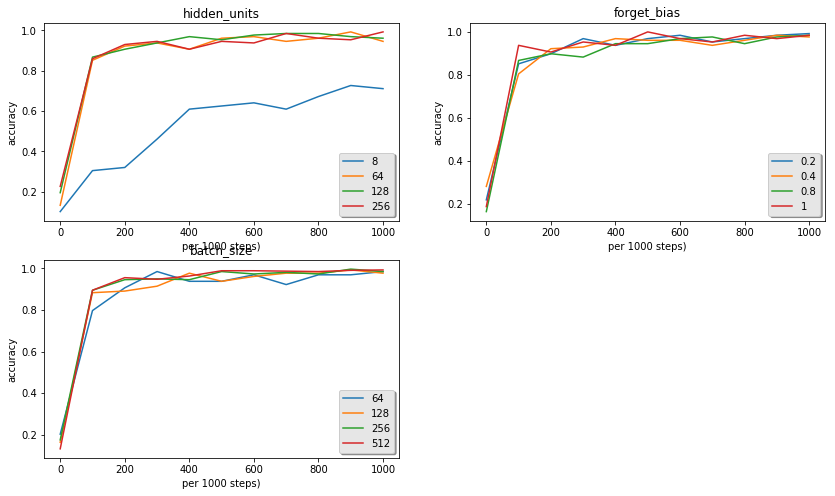

In [109]:
# 绘制不同学习函数 accuracy的曲线
plt.figure(figsize=(14,8))
for param,param_val in enumerate(models):
    plt.subplot(221+param)
    for inner_key in models[param_val]:
        plt.plot(models[param_val][inner_key]['steps'],models[param_val][inner_key]['accuracy_s'],label=str(inner_key))
        plt.ylabel('accuracy')
        plt.xlabel('per 1000 steps)')
        plt.title(param_val)
        legend = plt.legend(loc='best',shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
plt.show()